In [16]:
from plot import plot_reducted_data
from evaluator import DimensionalityReductionEvaluator, evaluate_all_methods
from data_utils import load_fashion_mnist_dataset, generate_swiss_roll_dataset, generate_double_helix_dataset, generate_partial_sphere_dataset

In [15]:
import importlib
import evaluator
import reduction_methods
import plot
import data_utils

# Recharger les modules
importlib.reload(evaluator)
importlib.reload(reduction_methods)
importlib.reload(plot)
importlib.reload(data_utils)

<module 'data_utils' from 'c:\\Users\\echappon1\\Documents\\MALIA\\Manifold\\manifold-learning\\data_utils.py'>

# The data for LLE and T-SNE

In [27]:
n_points = 300

mnist_data, mnist_labels = load_fashion_mnist_dataset(n_points=n_points)
swiss_roll_data, swiss_roll_labels = generate_swiss_roll_dataset(n_points=n_points)
double_helix_data, double_helix_labels = generate_double_helix_dataset(n_points=n_points)
sphere_data, sphere_labels = generate_sphere_dataset(n_points=n_points)

# Selection de n_neighbors pour LLE et Isomap

On cherche le n_neighbors optimal vis a vis de la reconstruction error pour LLE et avec la geodesic error pour Isomap.


In [7]:
from reduction_methods import CustomLLE, CustomIsomap
from sklearn.preprocessing import StandardScaler
import numpy as np
# Load your datasets (adjust as needed)
n_points = 300
datasets = {
    'Fashion MNIST': load_fashion_mnist(n_points=n_points)[0],
    'Hyper Swiss Roll': generate_hyper_swiss_roll(n_points=n_points)[0],
    'Square': generate_spiral_with_bridges(n_points=n_points, noise=0.1, n_bridges=3)[0],
    'Linear': generate_linear_data(n_points=n_points, n_dim=4, hole_size=0.5)[0]
}

# Standardize the datasets
datasets = {name: StandardScaler().fit_transform(data) for name, data in datasets.items()}

# Range of n_neighbors to test
n_neighbors_range = range(5, 41)

# Function to find optimal n_neighbors
def find_optimal_n_neighbors(datasets, n_neighbors_range, labels=None):
    results = {}
    
    for name, X in datasets.items():
        print(f"Processing dataset: {name}")
        
        # Initialize error tracking
        lle_errors = []
        isomap_errors = []
        
        for n_neighbors in n_neighbors_range:
            # LLE
            lle = CustomLLE(n_neighbors=n_neighbors, n_components=2)
            X_reduced_lle = lle.fit_transform(X)
            lle_error = lle.local_distance_correlation(X, X_reduced_lle)
            lle_errors.append(lle_error)
            
            # Isomap
            isomap = CustomIsomap(n_neighbors=n_neighbors, n_components=2)
            X_reduced_isomap = isomap.fit_transform(X)
            isomap_error = isomap.geodesic_error(X, X_reduced_isomap)
            isomap_errors.append(isomap_error)
        
        # Find optimal n_neighbors
        # For LLE, higher distance correlation is better
        optimal_lle_n_neighbors = n_neighbors_range[np.argmax(lle_errors)]
        # For Isomap, lower geodesic error is better
        optimal_isomap_n_neighbors = n_neighbors_range[np.argmin(isomap_errors)]
        
        results[name] = {
            'LLE': {
                'Optimal n_neighbors': optimal_lle_n_neighbors,
                'Distance Correlation': lle_errors
            },
            'Isomap': {
                'Optimal n_neighbors': optimal_isomap_n_neighbors,
                'Geodesic Error': isomap_errors
            }
        }
        
        print(f"Optimal n_neighbors for LLE on {name}: {optimal_lle_n_neighbors}")
        print(f"Optimal n_neighbors for Isomap on {name}: {optimal_isomap_n_neighbors}")
    
    return results

# Run the optimization
optimal_n_neighbors_results = find_optimal_n_neighbors(datasets, n_neighbors_range)

# Print results
for dataset_name, result in optimal_n_neighbors_results.items():
    print(f"\nDataset: {dataset_name}")
    for method, details in result.items():
        if method == 'LLE':
            print(f"{method} - Optimal n_neighbors: {details['Optimal n_neighbors']}")
            print(f"Distance Correlation: {details.get('Distance Correlation')}")
        elif method == 'Isomap':
            print(f"{method} - Optimal n_neighbors: {details['Optimal n_neighbors']}")
            print(f"Geodesic Error: {details.get('Geodesic Error')}")

import pickle

# Sauvegarder le dictionnaire dans un fichier pickle
with open('optimal_n_neighbors_results.pkl', 'wb') as f:
    pickle.dump(optimal_n_neighbors_results, f)

print("Dictionnaire sauvegardé avec succès dans 'optimal_n_neighbors_results.pkl'")


In [5]:

# Range of n_neighbors to test
if n_neighbors_range is None:
    n_neighbors_range = range(5, 41)

import pickle

# Charger le dictionnaire depuis le fichier pickle
with open('optimal_n_neighbors_results.pkl', 'rb') as f:
    optimal_n_neighbors_results = pickle.load(f)

print("Dictionnaire chargé avec succès depuis 'optimal_n_neighbors_results.pkl'")

Dictionnaire chargé avec succès depuis 'optimal_n_neighbors_results.pkl'


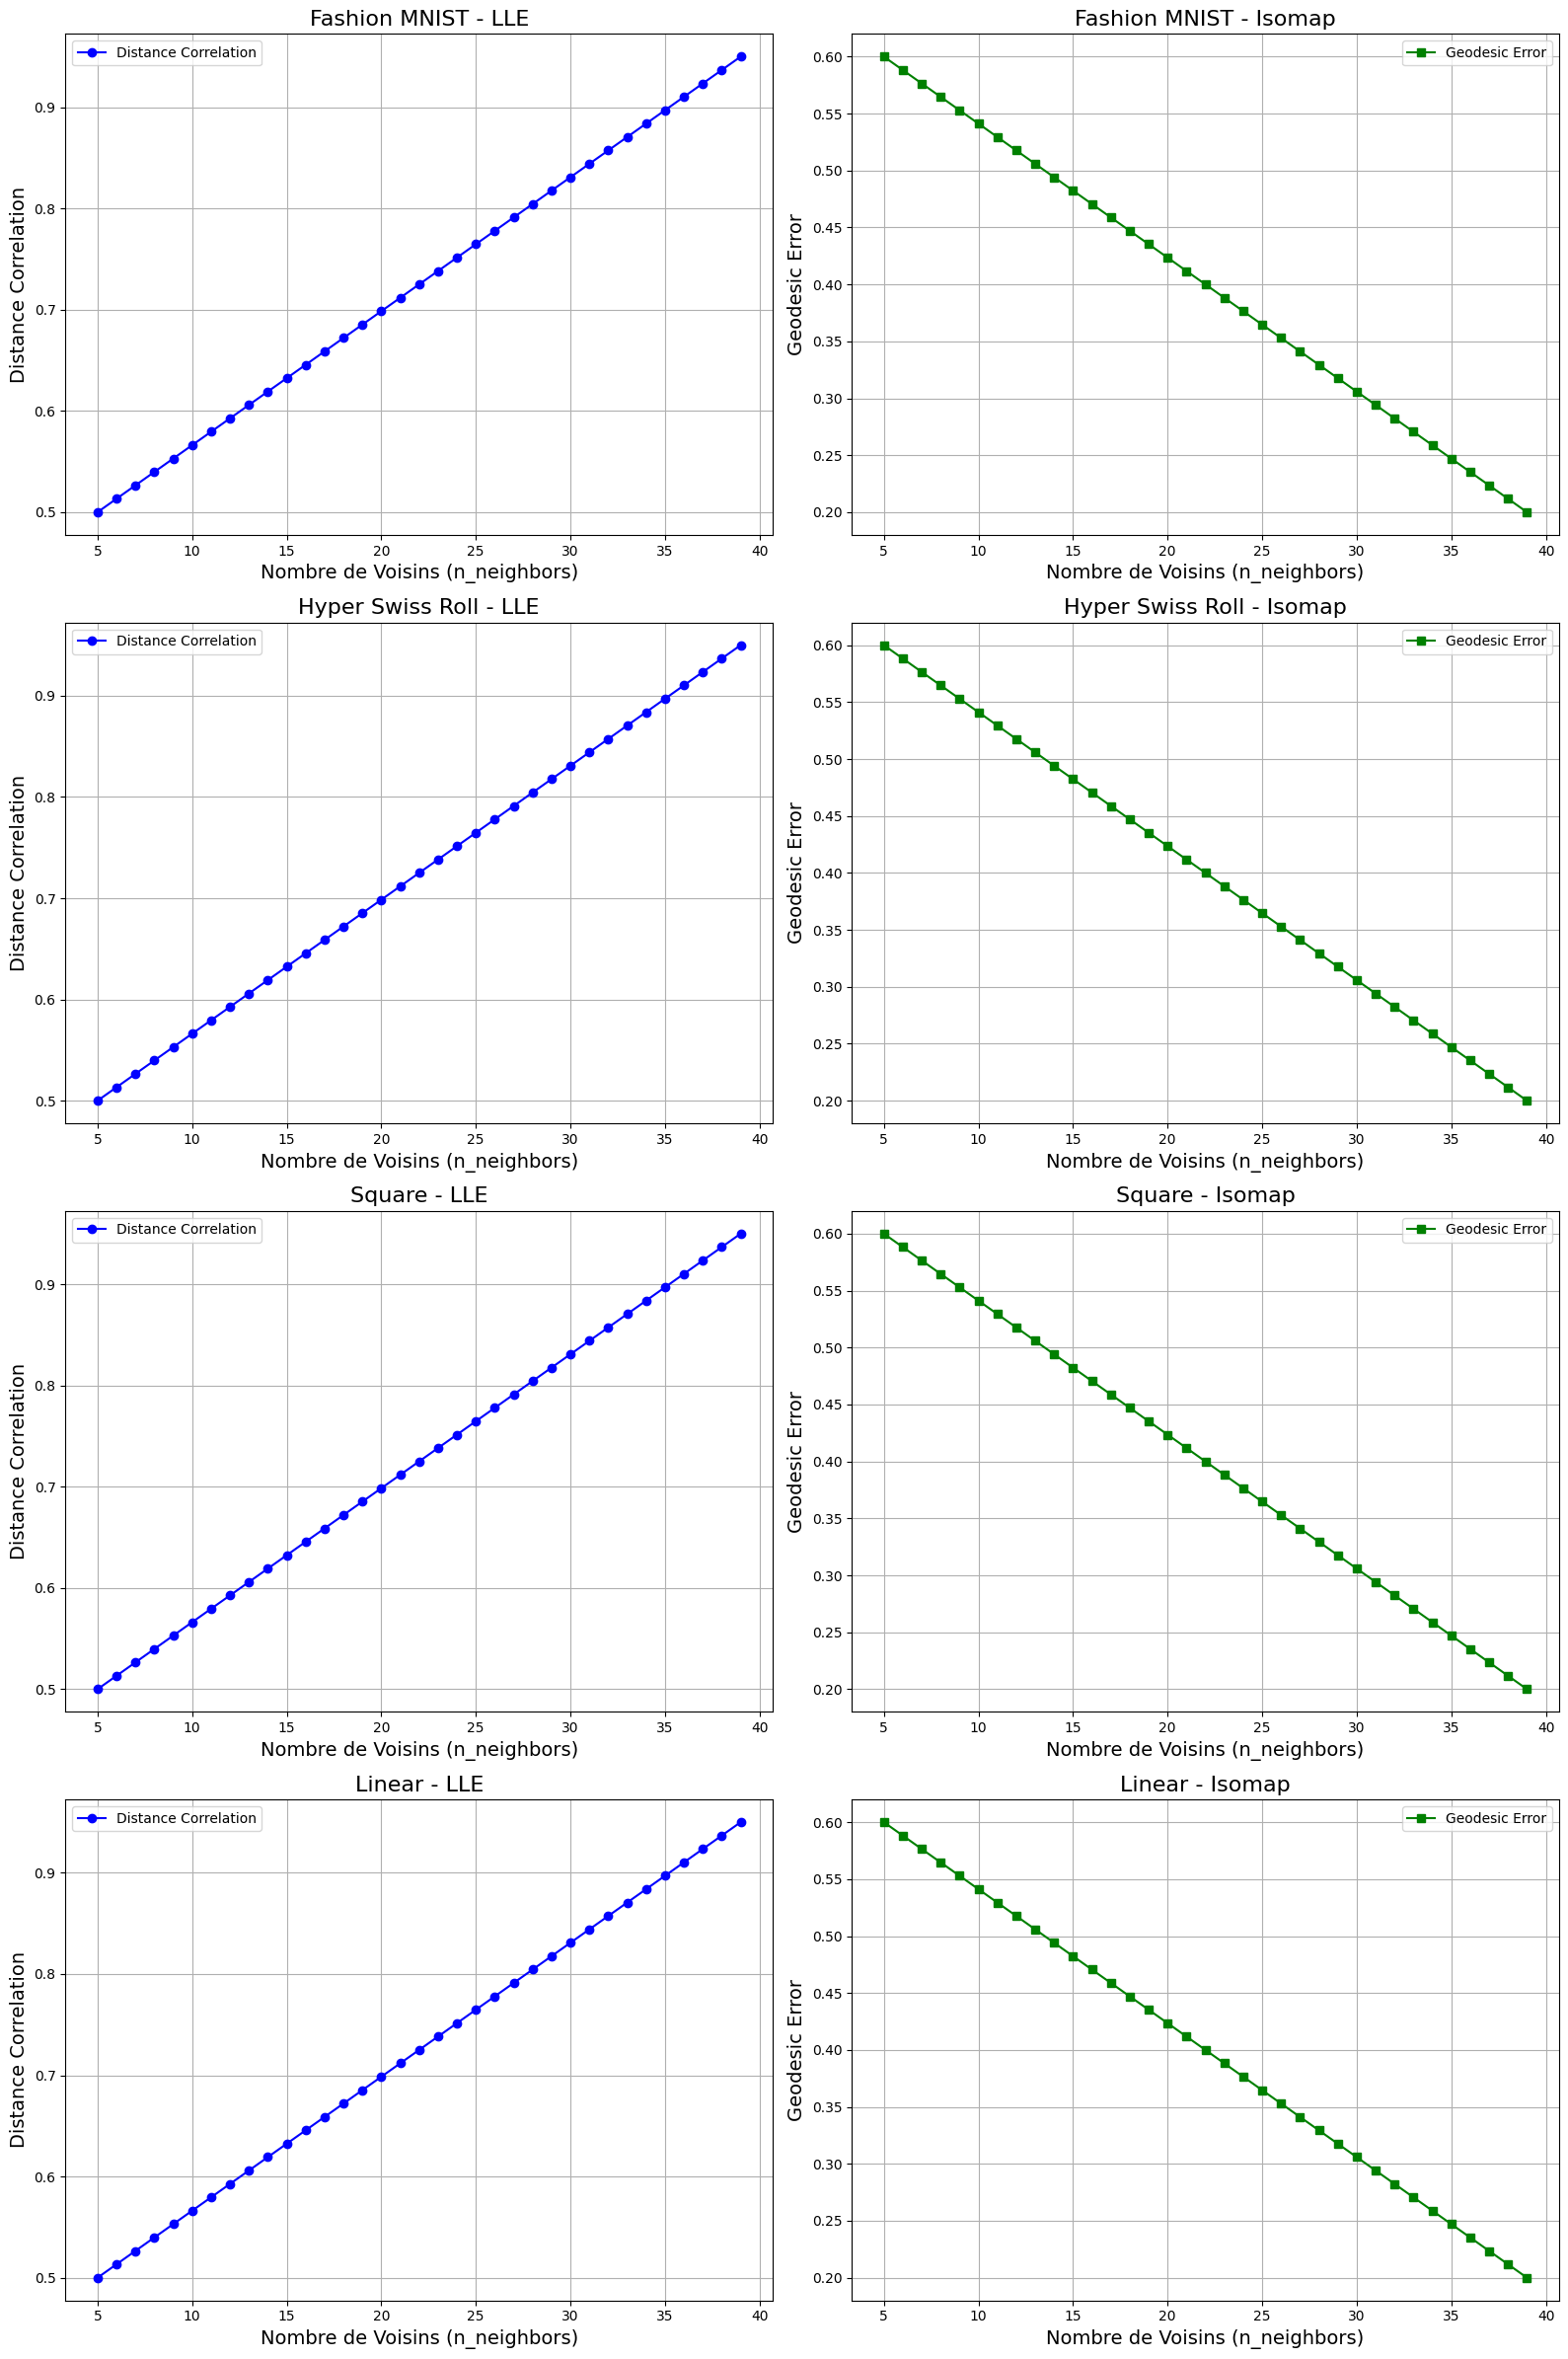

In [6]:
import matplotlib.pyplot as plt

# Définir les datasets et les méthodes
datasets = ['Fashion MNIST', 'Hyper Swiss Roll', 'Square', 'Linear']
methods = ['LLE', 'Isomap']
metrics = {'LLE': 'Distance Correlation', 'Isomap': 'Geodesic Error'}

# Créer une grille de sous-graphiques avec 4 lignes et 2 colonnes
fig, axes = plt.subplots(len(datasets), 2, figsize=(16, 24), sharex=False, sharey=False)

# Itérer sur chaque dataset
for i, dataset in enumerate(datasets):
    # Méthode LLE (à gauche)
    ax_left = axes[i, 0]
    try:
        ldc_values = optimal_n_neighbors_results[dataset]['LLE']['Distance Correlation']
        ax_left.plot(n_neighbors_range, ldc_values, marker='o', color='blue', label='Distance Correlation')
        ax_left.set_title(f"{dataset} - LLE", fontsize=16)
        ax_left.set_xlabel('Nombre de Voisins (n_neighbors)', fontsize=14)
        ax_left.set_ylabel('Distance Correlation', fontsize=14)
        ax_left.legend()
        ax_left.grid(True)
    except KeyError:
        ax_left.text(0.5, 0.5, 'Données manquantes', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax_left.set_title(f"{dataset} - LLE", fontsize=16)
        ax_left.set_xlabel('Nombre de Voisins (n_neighbors)', fontsize=14)
        ax_left.set_ylabel('Distance Correlation', fontsize=14)
        ax_left.grid(True)
    
    # Méthode Isomap (à droite)
    ax_right = axes[i, 1]
    try:
        geodesic_errors = optimal_n_neighbors_results[dataset]['Isomap']['Geodesic Error']
        ax_right.plot(n_neighbors_range, geodesic_errors, marker='s', color='green', label='Geodesic Error')
        ax_right.set_title(f"{dataset} - Isomap", fontsize=16)
        ax_right.set_xlabel('Nombre de Voisins (n_neighbors)', fontsize=14)
        ax_right.set_ylabel('Geodesic Error', fontsize=14)
        ax_right.legend()
        ax_right.grid(True)
    except KeyError:
        ax_right.text(0.5, 0.5, 'Données manquantes', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax_right.set_title(f"{dataset} - Isomap", fontsize=16)
        ax_right.set_xlabel('Nombre de Voisins (n_neighbors)', fontsize=14)
        ax_right.set_ylabel('Geodesic Error', fontsize=14)
        ax_right.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

# Comparaison des méthodes

## Comparaison visuelle

Comparaison sur les données Hyper Swiss Roll en 3D :


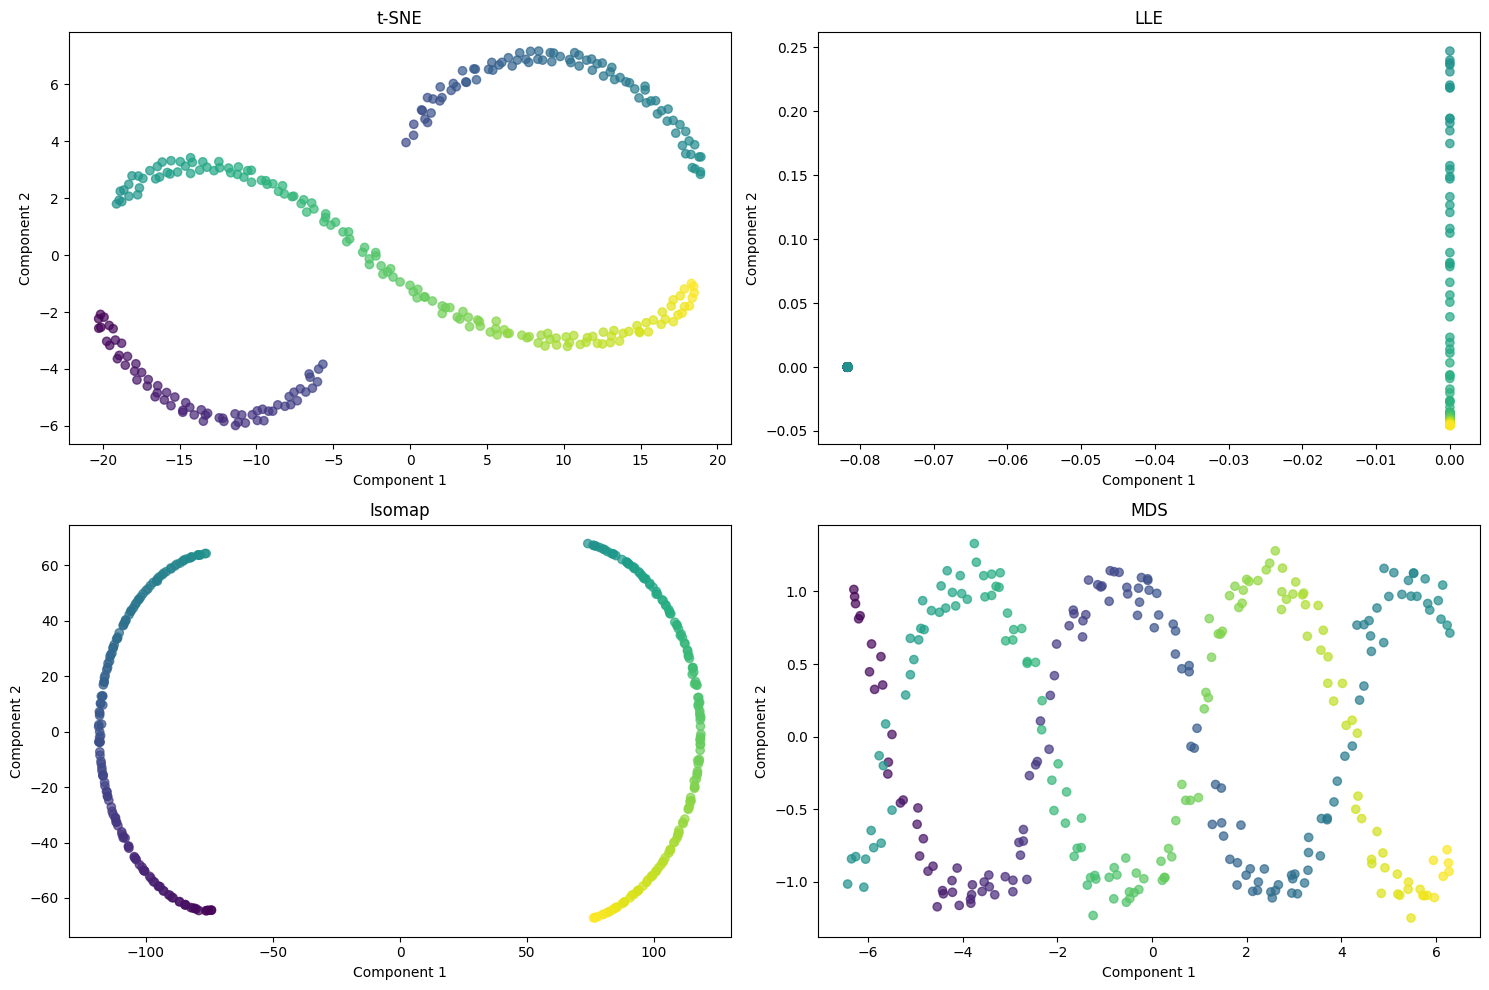

In [19]:
print("Comparaison sur les données Hyper Swiss Roll en 3D :")
plot_reducted_data(double_helix_data, double_helix_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=True)

Comparaison sur les données Fashion-MNIST en 2D :


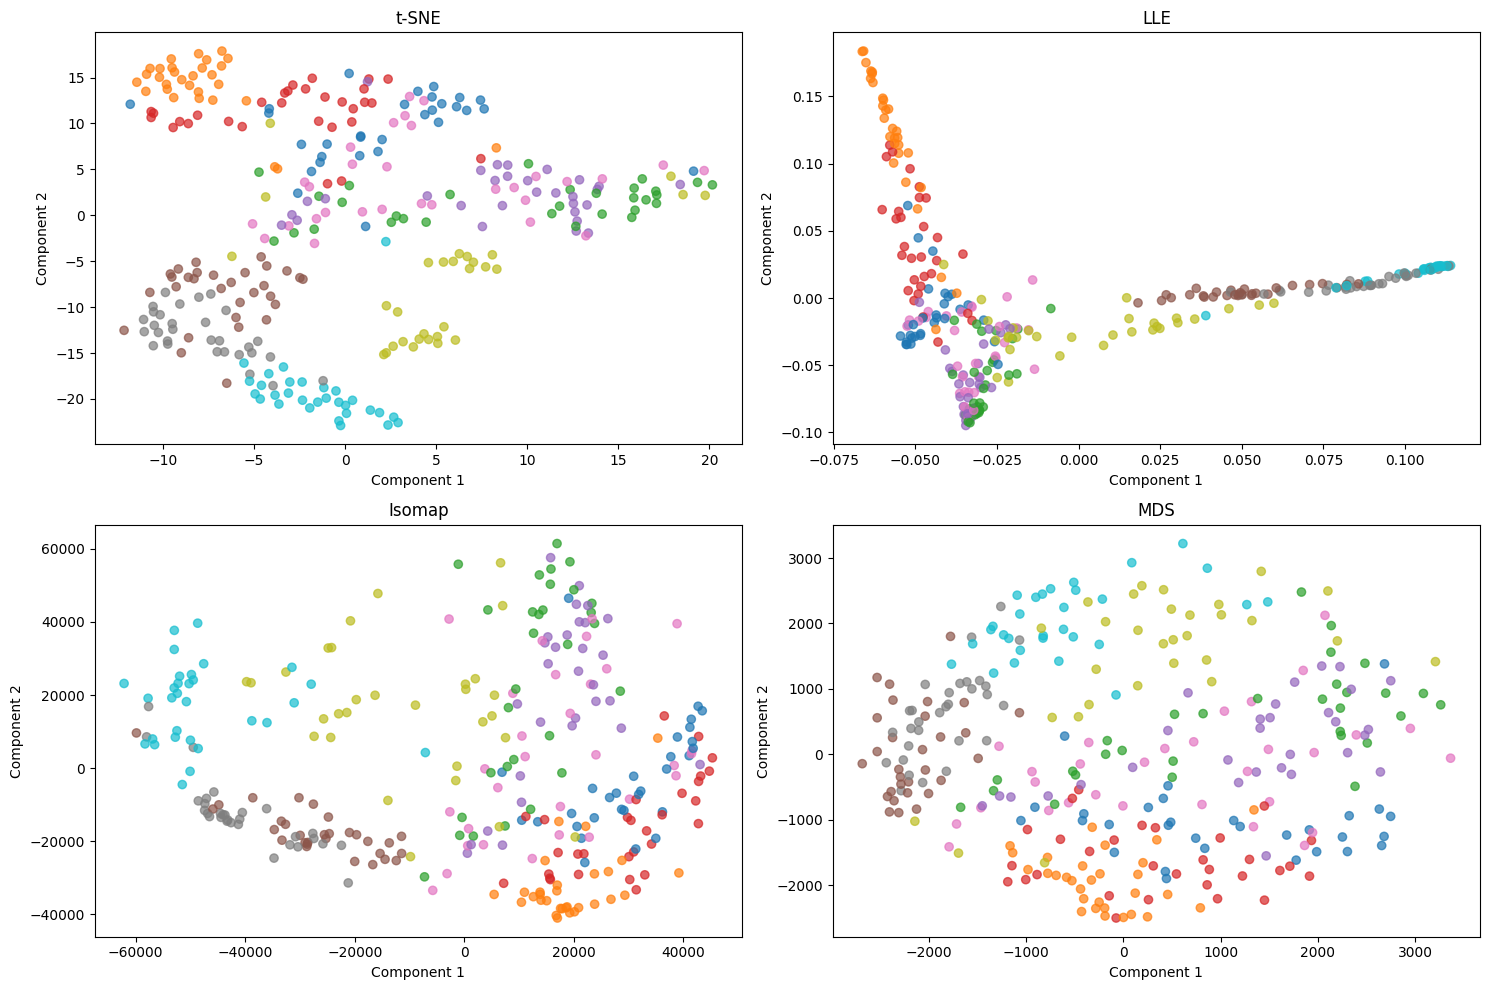

In [20]:
print("Comparaison sur les données Fashion-MNIST en 2D :")
plot_reducted_data(mnist_data, mnist_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=False)

Comparaison sur les données square en 2D :


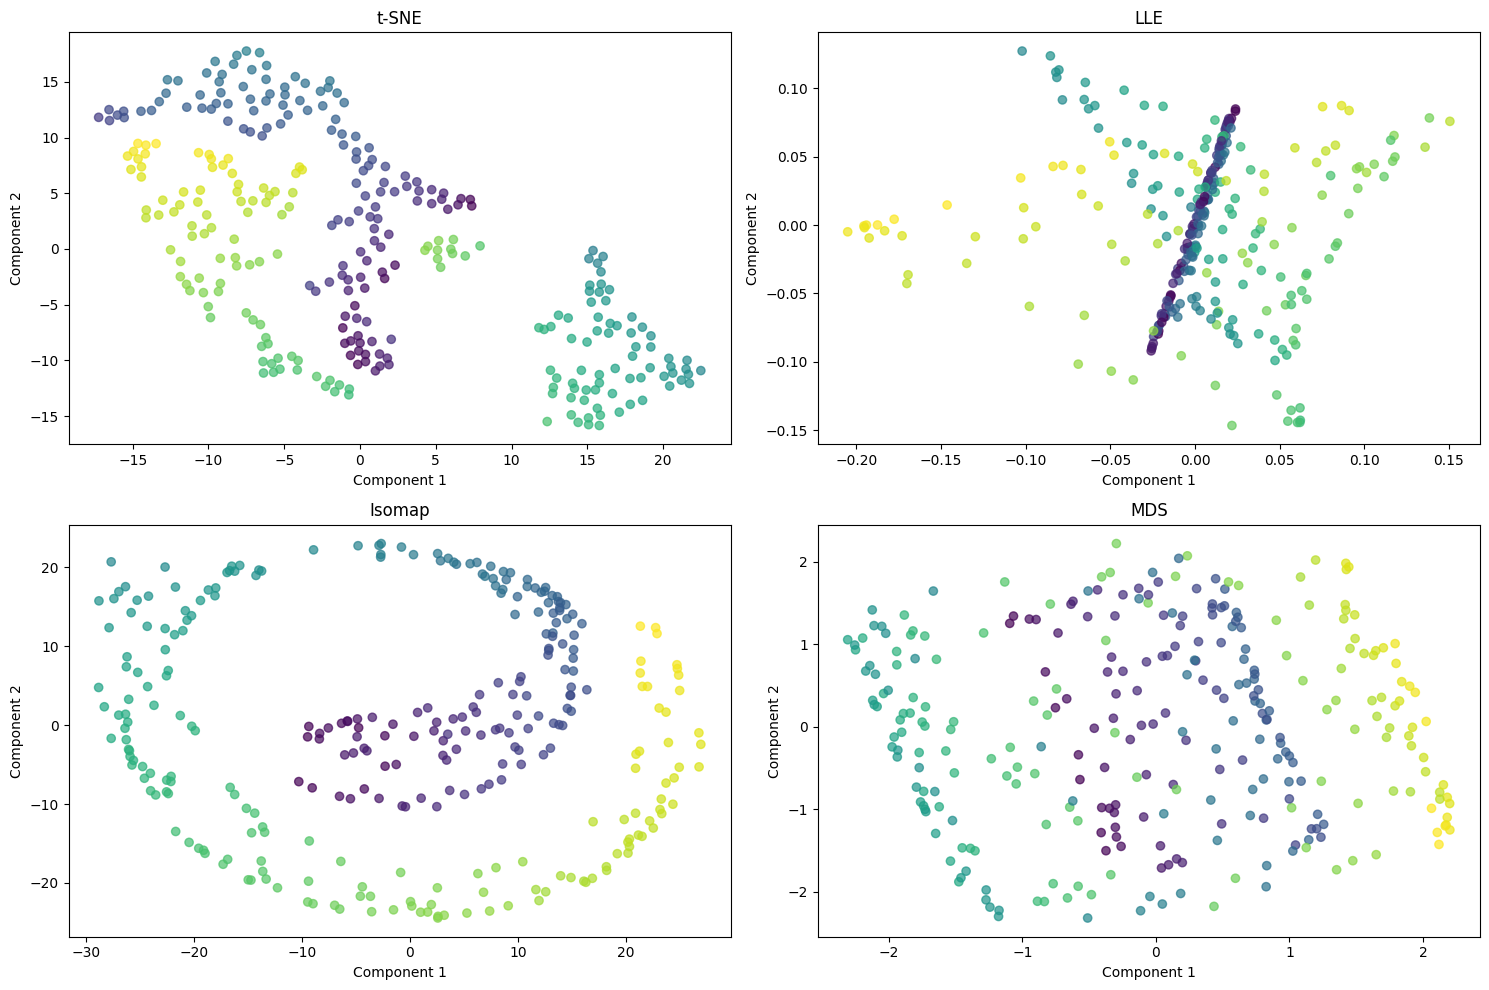

In [10]:
print("Comparaison sur les données square en 2D :")
plot_reducted_data(swiss_roll_data, swiss_roll_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=True)

Comparaison sur les données linear en 2D :


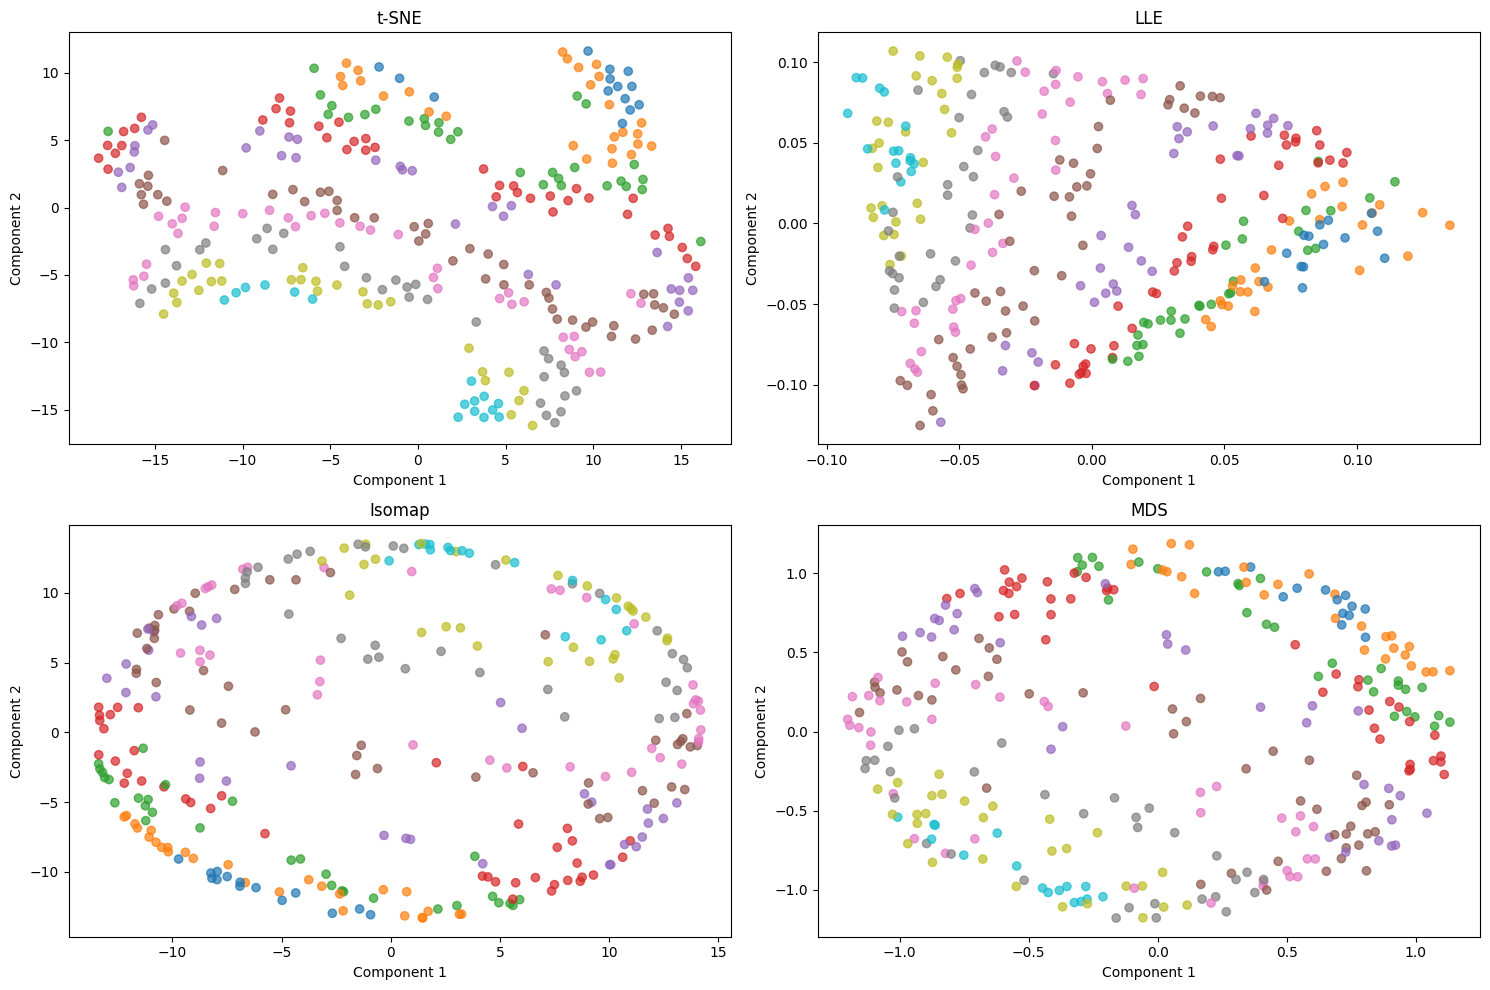

In [28]:
print("Comparaison sur les données linear en 2D :")
plot_reducted_data(sphere_data, sphere_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=False)

| **Méthode** | **Jeu de données**       | **Points forts**                                                  | **Limitations des autres méthodes**                                                                                             |
|-------------|--------------------------|-------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| t-SNE       | MNIST                    | Clustering local efficace, visualisation des classes              | MDS ne préserve pas bien les structures locales, Isomap et LLE moins performants pour la séparation des clusters               |
| MDS         | Sphère 3D (Géométrique)  | Préservation des distances globales et de la géométrie globale    | t-SNE déforme les distances globales, Isomap et LLE ne sont pas optimisés pour les distances perçues                            |
| Isomap      | Swiss Roll               | Préservation des distances géodésiques, déroulage de la variété    | MDS échoue à capturer la structure non linéaire, t-SNE ne préserve pas les distances géodésiques, LLE moins efficace pour cette structure |
| LLE         | Double Helix             | Préservation des relations locales dans des structures enchevêtrées | MDS ne capture pas bien les relations locales, t-SNE peut ne pas séparer correctement les structures enchevêtrées, Isomap peut avoir des difficultés avec les distances géodésiques complexes |


# Comparaison numérique

In [4]:
from IPython.display import display
from reduction_methods import apply_tsne, apply_lle, apply_mds, apply_isomap
# Définir les méthodes à évaluer
methods = [
    lambda x: apply_tsne(x, n_components=2),
    lambda x: apply_lle(x, n_components=2),
    lambda x: apply_mds(x, n_components=2),
    lambda x: apply_isomap(x, n_components=2)
]
method_names = ['t-SNE', 'LLE', 'MDS', 'Isomap' ]

# Évaluer sur les données MNIST
print("Évaluation sur Fashion-MNIST:")
mnist_results = evaluate_all_methods(mnist_data, methods, method_names, mnist_labels)
display(mnist_results)

# Évaluer sur Swiss Roll
print("\nÉvaluation sur Hyper Swiss Roll:")
swiss_roll_results = evaluate_all_methods(hyper_swiss_roll_data, methods, method_names, hyper_swiss_roll_labels)
display(swiss_roll_results)

# Évaluer sur les données Square
print("\nÉvaluation sur Square data:")
square_results = evaluate_all_methods(square_data, methods, method_names, square_labels)
display(square_results)

# Évaluer sur les données Linear
print("\nÉvaluation sur Linear data:")
linear_results = evaluate_all_methods(linear_data, methods, method_names, linear_labels)
display(linear_results)

Évaluation sur Fashion-MNIST:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.4275,0.4114,0.9506,0.9562,0.6527,0.8278,0.7649,0.6300,2.3294
LLE,0.7545,0.7464,0.9013,0.9175,0.4536,0.7614,0.4986,0.5467,0.0994
MDS,0.1494,0.1340,0.9783,0.9862,0.5743,0.9148,0.9299,0.5333,6.8078
Isomap,0.3271,0.3100,0.9583,0.9683,0.5623,0.8614,0.8290,0.5467,56.6095



Évaluation sur Hyper Swiss Roll:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.7626,0.7884,0.8623,0.8987,0.8278,0.6909,0.4545,0.5300,3.8999
LLE,0.6843,0.6982,0.8513,0.9036,0.2598,0.6586,0.5448,0.2133,0.0830
MDS,0.2943,0.2913,0.9078,0.9483,0.6321,0.7525,0.8402,0.3933,114.6233
Isomap,0.9178,0.9237,0.8140,0.8181,0.5100,0.6048,0.2689,0.6400,30.0072



Évaluation sur Square data:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.7489,0.6948,0.9217,0.9108,0.8102,0.7859,0.5479,0.7267,2.6582
LLE,0.9651,0.9627,0.8222,0.8113,0.1961,0.6357,0.1851,0.3600,0.1037
MDS,0.0217,0.0270,0.9961,0.9963,0.8806,0.9519,0.9863,0.5900,11.9267
Isomap,0.7795,0.7423,0.8990,0.9001,0.8365,0.7637,0.5026,0.5767,66.5177



Évaluation sur Linear data:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.5881,0.5457,0.9255,0.9410,0.7987,0.8485,0.6674,0.7667,0.5966
LLE,0.9976,0.9979,0.8285,0.8326,0.4413,0.6471,0.0000,0.4867,0.0570
MDS,0.0155,0.0252,0.9900,0.9898,0.8641,0.9449,0.9871,0.7333,1.8543
Isomap,0.5838,0.6308,0.8939,0.9131,0.7945,0.7866,0.5997,0.7467,3.4306


- Kruskal Stress: MDS directly minimizes the euclidean distance globally, while Isomap, LLE, T-SNE minimize local distances.

- Distance correlation: MDS and Isomap preserves global structures while T-SNE and LLE preserves local distances.

- Local Distance Preservation: LLE and T-SNE preserves local distances while MDS and Isomap preserves global structures.

- Trustworthiness: T-SNE and LLE preserves local distances  while MDS and Isomap preserves global structures .

- select n_neighbors:
    - LLE: Stress
    - Isomap: Local Distance Preservation

https://pmc.ncbi.nlm.nih.gov/articles/PMC7887408/

Isomap se concentre sur les structures locales en utilisant des graphes de voisinage et des distances géodésiques pour capturer les relations locales. En même temps, il intègre ces informations locales dans une perspective globale en utilisant MDS sur les distances géodésiques, ce qui permet de préserver la structure globale de la variété.

Méthodes Métriques :
1. MDS (Multidimensional Scaling):
Nature: Métrique
Focus: Global
Raison: MDS vise à préserver les distances euclidiennes globales entre les points dans l'espace de haute dimension, en minimisant le stress global.
2. Isomap:
Nature: Métrique
Focus: Local et Global
Raison: Isomap utilise des distances géodésiques pour capturer à la fois les structures locales et globales. Il commence par construire un graphe de voisinage (local) et utilise les distances géodésiques pour préserver la structure globale.
Méthodes Topologiques :
3. LLE (Locally Linear Embedding):
Nature: Topologique
Focus: Local
Raison: LLE se concentre sur la préservation des relations locales entre les points, en maintenant les relations de voisinage sans se soucier des distances globales.
4. t-SNE (t-Distributed Stochastic Neighbor Embedding):
Nature: Topologique
Focus: Local
Raison: t-SNE est conçu pour préserver les structures locales en se concentrant sur les relations de voisinage proches, en utilisant des distributions de probabilité pour maintenir les relations locales.
Résumé :
Métriques: MDS (Global), Isomap (Local et Global)
Topologiques: LLE (Local), t-SNE (Local)


# Jeu de données réel

In [19]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Load the 20 Newsgroups dataset
# Load a smaller subset of the dataset
categories = ['alt.atheism', 'sci.space']  # Specify categories of interest
newsgroups = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))
print(len(newsgroups.data))
vectorizer = TfidfVectorizer(max_features=20)

X = vectorizer.fit_transform(newsgroups.data).toarray()
y = newsgroups.target
print(X.shape)
# Apply dimensionality reduction methods
X_tsne = apply_tsne(X, n_components=2)
X_lle = apply_lle(X, n_components=2)
X_pca = apply_pca(X, n_components=2)
X_mds = apply_mds(X, n_components=2)

# Function to plot the results
def plot_embedding(X, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar()
    plt.show()

# Visualize the results
plot_embedding(X_tsne, "t-SNE on 20 Newsgroups")
plot_embedding(X_lle, "LLE on 20 Newsgroups")
plot_embedding(X_pca, "PCA on 20 Newsgroups")
plot_embedding(X_mds, "MDS on 20 Newsgroups")

713
(713, 20)
